In [1]:
import pandas as pd
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
X = train[list(test.columns)]
y = train[train.columns[~train.columns.isin(test.columns)]]

In [2]:
from sklearn.base import BaseEstimator, TransformerMixin

def extraiPronome(nome):
    return nome.split(',')[1].split('.')[0].strip()

class AtributosDesejados(BaseEstimator, TransformerMixin):
    def __init__(self, excluirName=True):
        self.excluirName = excluirName
    def fit(self, X, y=None):
        self.colunasIndesejadas = ['PassengerId', 'Ticket', 'Cabin']
        #a linha abaixo deu 0.8327 e com os parametros 'atributosDesejados__excluirName': [False], 'classificador__max_depth': [8], 'classificador__n_estimators': [545], 'classificador__max_features': ['log2'], 'classificador__warm_start': [True]
        #self.colunasIndesejadas = ['PassengerId', 'Ticket', 'Cabin', 'SibSp', 'Parch']
        if self.excluirName:
            self.colunasIndesejadas.append('Name')
        return self
    def transform(self, X, y=None):
        Xdrop = X.drop(self.colunasIndesejadas,axis=1)
        if 'Name' not in self.colunasIndesejadas:
            Xdrop['Name'] = Xdrop['Name'].apply(extraiPronome)
        return Xdrop


In [3]:
from sklearn.base import BaseEstimator, TransformerMixin

class AtributosNumericos(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.colunasNumericas = X.select_dtypes(include='number').columns
        return self
    def transform(self, X, y=None):
        return X[self.colunasNumericas].to_numpy()
    

In [4]:
from sklearn.base import BaseEstimator, TransformerMixin

class AtributosCategoricos(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.colunasCategoricas = X.select_dtypes(include='object').columns
        return self
    def transform(self, X, y=None):
        return X[self.colunasCategoricas].to_numpy()


In [5]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion

trataAtributos = Pipeline([
    ('unecaracteristicas', FeatureUnion([
        ('pipenum', Pipeline([
            ('atributos_numericos', AtributosNumericos()),
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ])),
        ('pipecat', Pipeline([
            ('atributos_categoricos', AtributosCategoricos()),
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(handle_unknown='ignore'))
        ]))
    ])),
])


<hr style="height:2px;border-width:0;color:black;background-color:black">
A primeira avaliação que me veio a cabeça foi alterar a forma de tratamento do nome, pois existem mais de 17 categorias. Minha idéia foi simplificar conforme abaixo

In [6]:
X.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
#avaliando a quantidade de pronomes gerados pela redução dos nomes
atributos = AtributosDesejados(excluirName=False)
atributos.fit(X)
new_x = atributos.transform(X)
new_x.value_counts('Name')

Name
Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Col               2
Mlle              2
Major             2
Jonkheer          1
Don               1
the Countess      1
Lady              1
Sir               1
Mme               1
Ms                1
Capt              1
dtype: int64

In [8]:
#A exceção de Mr, Miss e Mrs, o código abaixo é para avaliar os títulos por sexo
print(new_x['Name'].unique()[3:]+'. ')

for value in new_x['Name'].unique()[3:]+'. ':
    print(X[X['Name'].str.contains(value)][['Name','Sex']])

['Master. ' 'Don. ' 'Rev. ' 'Dr. ' 'Mme. ' 'Ms. ' 'Major. ' 'Lady. '
 'Sir. ' 'Mlle. ' 'Col. ' 'Capt. ' 'the Countess. ' 'Jonkheer. ']
                                                  Name   Sex
7                       Palsson, Master. Gosta Leonard  male
16                                Rice, Master. Eugene  male
50                          Panula, Master. Juha Niilo  male
59                  Goodwin, Master. William Frederick  male
63                               Skoog, Master. Harald  male
65                            Moubarek, Master. Gerios  male
78                       Caldwell, Master. Alden Gates  male
125                       Nicola-Yarred, Master. Elias  male
159                         Sage, Master. Thomas Henry  male
164                       Panula, Master. Eino Viljami  male
165    Goldsmith, Master. Frank John William "Frankie"  male
171                               Rice, Master. Arthur  male
176                      Lefebre, Master. Henry Forbes  male
182        

In [9]:
#Os títulos estão bem diversificados, a maioria se resume em Mr., Miss, Mrs
#Pela tabela acima da para ter uma boa ideia dos outros títulos, e para isso vou simplificar o restante eles para Mr se for masculino e Ms se for feminino
# 
# Mr - Usada para gêneros masculinos. Não importa se a pessoa é casada ou não. Deve ser usado antes do sobrenome.
# Mrs - Usado para mulheres casadas. Também é usado antes do sobrenome.
# Miss - É usado para mulheres que não se casaram ainda. Também usado antes do sobrenome
# Ms - Usado para mulheres, tanto solteiras ou casadas. Esse título geralmente é usado quando não sabemos se a pessoa é casada ou não.
# Fonte: https://www.kaplaninternational.com/br/blog/quando-usar-os-titulo-pessoais-miss-ms-e-mrs-em-ingles
from sklearn.base import BaseEstimator, TransformerMixin

def extraiPronome(nome):
    return nome.split(',')[1].split('.')[0].strip()

class AtributosDesejados(BaseEstimator, TransformerMixin):
    def __init__(self, excluirName=True):
        self.excluirName = excluirName
    def fit(self, X, y=None):
        self.colunasIndesejadas = ['PassengerId', 'Ticket', 'Cabin']
        if self.excluirName:
            self.colunasIndesejadas.append('Name')
        return self
    def transform(self, X, y=None):
        Xdrop = X.drop(self.colunasIndesejadas,axis=1)
        if 'Name' not in self.colunasIndesejadas:
            Xdrop['Name'] = Xdrop['Name'].apply(extraiPronome)
            Xdrop['Name'] = Xdrop['Name'].replace('Don','Mr')
            Xdrop['Name'] = Xdrop['Name'].replace('Rev','Mr')
            Xdrop['Name'] = Xdrop['Name'].replace('Mme','Ms')
            Xdrop['Name'] = Xdrop['Name'].replace('Major','Mr')
            Xdrop['Name'] = Xdrop['Name'].replace('Lady','Ms')
            Xdrop['Name'] = Xdrop['Name'].replace('Sir','Mr')
            #o caso abaixo está esplicito no nome que é Mrs
            Xdrop['Name'] = Xdrop['Name'].replace('Mlle','Mrs')
            Xdrop['Name'] = Xdrop['Name'].replace('Col','Mr')
            Xdrop['Name'] = Xdrop['Name'].replace('Capt','Mr')
            Xdrop['Name'] = Xdrop['Name'].replace('the Countess','Ms')
            Xdrop['Name'] = Xdrop['Name'].replace('Jonkheer','Mr')
            Xdrop['Name'] = Xdrop['Name'].replace('Dona','Ms')
            Xdrop['Name'] = Xdrop['Name'].replace('Dr','Mr')
            Xdrop['Name'] = Xdrop['Name'].replace('Master','Mr')
            
            #print(Xdrop.columns)
            #print(Xdrop['Name'].unique())
        return Xdrop


In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_validate, RepeatedKFold
import numpy as np

pipetotal = Pipeline([
    ('atributosDesejados', AtributosDesejados()),
    ('trataAtributos', trataAtributos),
    ('classificador', RandomForestClassifier())
])

parametros = {
    'atributosDesejados__excluirName': [True, False],
    'classificador__max_depth': [5]
}
modelo = GridSearchCV(pipetotal, param_grid=parametros)

scores = cross_validate(modelo, X, y['Survived'], cv=RepeatedKFold())
scores['test_score'], np.mean(scores['test_score']), np.std(scores['test_score'])

(array([0.79329609, 0.85393258, 0.83707865, 0.81460674, 0.78089888,
        0.81005587, 0.8258427 , 0.84269663, 0.76966292, 0.86516854,
        0.77653631, 0.85393258, 0.86516854, 0.80337079, 0.74719101,
        0.76536313, 0.83707865, 0.81460674, 0.83146067, 0.84831461,
        0.82681564, 0.74719101, 0.86516854, 0.83707865, 0.80898876,
        0.82122905, 0.79775281, 0.83146067, 0.78089888, 0.84831461,
        0.82122905, 0.83707865, 0.85955056, 0.81460674, 0.79213483,
        0.77653631, 0.83146067, 0.83707865, 0.8258427 , 0.80337079,
        0.79888268, 0.87078652, 0.83707865, 0.80898876, 0.79775281,
        0.81005587, 0.8258427 , 0.82022472, 0.84269663, 0.8258427 ]),
 0.8187640449438203,
 0.029805278849292648)

Somente simplificar os títulos não trouxe uma mudança significativa para o resultado
<hr style="height:2px;border-width:0;color:black;background-color:black">
Nessa próxima etapa irei avaliar a importância das características do Dataset

In [16]:
#para isso preciso inserir a função get_feature_names na classe de AtributosNumericos para ter uma noção das colunas que estão sendo concatenadas no FeatureUnion
class AtributosNumericos(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.colunasNumericas = X.select_dtypes(include='number').columns
        return self
    def transform(self, X, y=None):
        return X[self.colunasNumericas].to_numpy()
    def get_feature_names(self):
        return self.colunasNumericas
    
#preciso recompilar esse Pipeline tb
trataAtributos = Pipeline([
    ('unecaracteristicas', FeatureUnion([
        ('pipenum', Pipeline([
            ('atributos_numericos', AtributosNumericos()),
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ])),
        ('pipecat', Pipeline([
            ('atributos_categoricos', AtributosCategoricos()),
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(handle_unknown='ignore'))
        ]))
    ])),
])

In [17]:
#para avaliar, vou utilizar a função FeatureImportance do RandomForestClassifier, para isso, removi a parte do cross_validate, para avaliar somente o modelo
pipetotal = Pipeline([
    ('atributosDesejados', AtributosDesejados(excluirName=False)),
    ('trataAtributos', trataAtributos),
    ('classificador', RandomForestClassifier())
])

modelo = GridSearchCV(pipetotal, param_grid=parametros)
modelo.fit(X,y['Survived'])
print(modelo.best_score_)
print(modelo.best_params_)

0.8204255853367648
{'atributosDesejados__excluirName': False, 'classificador__max_depth': 5}


In [18]:
#chamando o atributo feature_imporanteces_ do melhor estimator
modelo.best_estimator_.steps[2][1].feature_importances_

array([0.11786373, 0.08509049, 0.04223524, 0.0279439 , 0.10641742,
       0.0531061 , 0.17387119, 0.03191511, 0.00086993, 0.15022447,
       0.1792557 , 0.01092936, 0.0081475 , 0.01212987])

In [19]:
#avaliando aqui os atributos contínuos (por isso que precisei implementar a função na classe anteriormente)
#IMPORTANTE: pela documentação do FeatureUnion, ele faz uma concatenação de ações, dessa forma estou considerando que as primeiras características do feature_importances_ são numéricas, e depois categóricas, pois assim que foi definido o pipeline 'unecaracterísticas'
modelo.best_estimator_['trataAtributos']['unecaracteristicas'].transformer_list[0][1][0].get_feature_names()

Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object')

In [20]:
#aqui chamo a função get_feature_names() do one_hot_encoder, pois ele é o último passo de transformação das características categóricas
modelo.best_estimator_['trataAtributos']['unecaracteristicas'].transformer_list[1][1]['encoder'].get_feature_names()

array(['x0_Miss', 'x0_Mr', 'x0_Mrs', 'x0_Ms', 'x1_female', 'x1_male',
       'x2_C', 'x2_Q', 'x2_S'], dtype=object)

In [21]:
#Dados os resultados, os atributos categóricos 'SibSp', 'Parch' tem um valor abaixo de 5% na avaliação.
#'Age' também tem, mas deixei ele, pois nas testes que fiz várias vezes ele melhora o resultado
#Os últimos três atributos relativos a embarque também tem um valor muito baixo de relevância para o Dataset
#Assim fiz as colunas indesejadas virarem ['PassengerId', 'Ticket', 'Cabin', 'SibSp', 'Parch', 'Embarked']
#O atributo 'Name' possui um item de característica relevante, então deixei ele

def extraiPronome(nome):
    return nome.split(',')[1].split('.')[0].strip()

class AtributosDesejados(BaseEstimator, TransformerMixin):
    def __init__(self, excluirName=True):
        self.excluirName = excluirName
    def fit(self, X, y=None):
        self.colunasIndesejadas = ['PassengerId', 'Ticket', 'Cabin', 'SibSp', 'Parch', 'Embarked']
        if self.excluirName:
            self.colunasIndesejadas.append('Name')
        return self
    def transform(self, X, y=None):
        Xdrop = X.drop(self.colunasIndesejadas,axis=1)
        if 'Name' not in self.colunasIndesejadas:
            Xdrop['Name'] = Xdrop['Name'].apply(extraiPronome)
            Xdrop['Name'] = Xdrop['Name'].replace('Don','Mr')
            Xdrop['Name'] = Xdrop['Name'].replace('Rev','Mr')
            Xdrop['Name'] = Xdrop['Name'].replace('Mme','Ms')
            Xdrop['Name'] = Xdrop['Name'].replace('Major','Mr')
            Xdrop['Name'] = Xdrop['Name'].replace('Lady','Ms')
            Xdrop['Name'] = Xdrop['Name'].replace('Sir','Mr')
            #o caso abaixo está esplicito no nome que é Mrs
            Xdrop['Name'] = Xdrop['Name'].replace('Mlle','Mrs')
            Xdrop['Name'] = Xdrop['Name'].replace('Col','Mr')
            Xdrop['Name'] = Xdrop['Name'].replace('Capt','Mr')
            Xdrop['Name'] = Xdrop['Name'].replace('the Countess','Ms')
            Xdrop['Name'] = Xdrop['Name'].replace('Jonkheer','Mr')
            Xdrop['Name'] = Xdrop['Name'].replace('Dona','Ms')
            Xdrop['Name'] = Xdrop['Name'].replace('Dr','Mr')
            Xdrop['Name'] = Xdrop['Name'].replace('Master','Mr')
            
            #print(Xdrop.columns)
            #print(Xdrop['Name'].unique())
        return Xdrop

In [25]:
#O resultado não melhora muito, mas combinando com a próxima etapa ele da um salto significativo
pipetotal = Pipeline([
    ('atributosDesejados', AtributosDesejados(excluirName=False)),
    ('trataAtributos', trataAtributos),
    ('classificador', RandomForestClassifier())
])

modelo = GridSearchCV(pipetotal, param_grid=parametros)
modelo.fit(X,y['Survived'])
print(modelo.best_score_)
print(modelo.best_params_)

0.8215680120519743
{'atributosDesejados__excluirName': False, 'classificador__max_depth': 5}


In [26]:
#tentei avaliar a possibilidade de fatiar os atributos Age e Fare
X.hist(column='Age',by=y['Survived'],bins=4)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001C7CB306A58>,
      dtype=object)

In [483]:
#avaliando o conjunto de 60 anos pra cima
pd.concat([X.loc[X.Age>60],y.loc[X.loc[X.Age>60].index]],axis=1)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
33,34,2,"Wheadon, Mr. Edward H",male,66.0,0,0,C.A. 24579,10.5000,NaN,S,0
54,55,1,"Ostby, Mr. Engelhart Cornelius",male,65.0,0,1,113509,61.9792,B30,C,0
96,97,1,"Goldschmidt, Mr. George B",male,71.0,0,0,PC 17754,34.6542,A5,C,0
116,117,3,"Connors, Mr. Patrick",male,70.5,0,0,370369,7.7500,NaN,Q,0
170,171,1,"Van der hoef, Mr. Wyckoff",male,61.0,0,0,111240,33.5000,B19,S,0
252,253,1,"Stead, Mr. William Thomas",male,62.0,0,0,113514,26.5500,C87,S,0
275,276,1,"Andrews, Miss. Kornelia Theodosia",female,63.0,1,0,13502,77.9583,D7,S,1
280,281,3,"Duane, Mr. Frank",male,65.0,0,0,336439,7.7500,NaN,Q,0
326,327,3,"Nysveen, Mr. Johan Hansen",male,61.0,0,0,345364,6.2375,NaN,S,0
438,439,1,"Fortune, Mr. Mark",male,64.0,1,4,19950,263.0000,C23 C25 C27,S,0


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001C7CB569D68>,
      dtype=object)

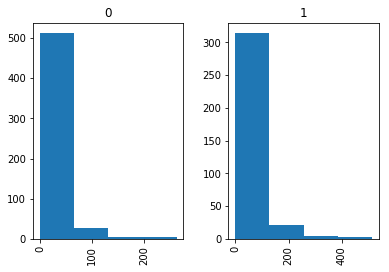

In [27]:
#avaliando a divisão de Fare por sobrevivente
X.hist(column='Fare',by=y['Survived'],bins=4)

In [28]:
#avaliando o conjunto de Fare maior que 263
pd.concat([X.loc[X.Fare>263],y.loc[X.loc[X.Fare>263].index]],axis=1)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
258,259,1,"Ward, Miss. Anna",female,35.0,0,0,PC 17755,512.3292,NaN,C,1
679,680,1,"Cardeza, Mr. Thomas Drake Martinez",male,36.0,0,1,PC 17755,512.3292,B51 B53 B55,C,1
737,738,1,"Lesurer, Mr. Gustave J",male,35.0,0,0,PC 17755,512.3292,B101,C,1


In [29]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

#aqui eu fiz várias divisões de Age, e de Fare, mas o resultado da relevância para o Dataset não foi bom para nenhum dos dois atributos
#nessa célula estão somente as alterações de Age, mas fiz de Fare também, e aqui está somente a última divisão do conjunto que eu fiz, mas tentei de várias formas diferentes.
train['Age'].fillna(train['Age'].median(),inplace=True)
test['Age'].fillna(train['Age'].median(),inplace=True)
train.loc[train['Age'] <= 5, 'new_Age'] = 'Age1'
train.loc[(train['Age'] > 5) & (train['Age'] <= 63), 'new_Age'] = 'Age2'
train.loc[ train['Age'] > 63, 'new_Age'] = 'Age5'
train.drop(labels='Age',axis=1,inplace=True)

test.loc[test['Age'] <= 5, 'new_Age'] = 'Age1'
test.loc[(test['Age'] > 5) & (test['Age'] <= 63), 'new_Age'] = 'Age2'
test.loc[ test['Age'] > 63, 'new_Age'] = 'Age5'
test.drop(labels='Age',axis=1,inplace=True)

X = train[list(test.columns)]
y = train[train.columns[~train.columns.isin(test.columns)]]

In [30]:
pipetotal = Pipeline([
    ('atributosDesejados', AtributosDesejados(excluirName=False)),
    ('trataAtributos', trataAtributos),
    ('classificador', RandomForestClassifier())
])

modelo = GridSearchCV(pipetotal, param_grid=parametros)
modelo.fit(X,y['Survived'])
print(modelo.best_score_)
print(modelo.best_params_)

0.8237838177138912
{'atributosDesejados__excluirName': True, 'classificador__max_depth': 5}


In [31]:
print(modelo.best_estimator_.steps[2][1].feature_importances_)
print(modelo.best_estimator_['trataAtributos']['unecaracteristicas'].transformer_list[0][1][0].get_feature_names())
print(modelo.best_estimator_['trataAtributos']['unecaracteristicas'].transformer_list[1][1]['encoder'].get_feature_names())

[0.17046862 0.21188585 0.27099419 0.27898606 0.03763677 0.02138835
 0.00864016]
Index(['Pclass', 'Fare'], dtype='object')
['x0_female' 'x0_male' 'x1_Age1' 'x1_Age2' 'x1_Age5']


A célula anterior mostra que dividir Age em grupos foi pior
<hr style="height:2px;border-width:0;color:black;background-color:black">
O próximo passo foi tentar refinar os parâmetros do algoritmo de RandomForest, e do cross-validate

In [32]:
#voltando para o dataset original
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
X = train[list(test.columns)]
y = train[train.columns[~train.columns.isin(test.columns)]]

In [33]:
pipetotal = Pipeline([
    ('atributosDesejados', AtributosDesejados(excluirName=False)),
    ('trataAtributos', trataAtributos),
    ('classificador', RandomForestClassifier())
])

#aqui fiz várias tentativas com os parâmetros abaixo, e estes foram os que apresentaram melhores resultados, inclusive, fica explícito que o atributo de nome não faz diferença
parametros = {
    'atributosDesejados__excluirName': [True],
    'classificador__max_depth': [8],
    'classificador__n_estimators': [545],
    'classificador__max_features': ['log2'],
    'classificador__criterion': ['entropy'],
    'classificador__max_leaf_nodes': [61],
    'classificador__oob_score': [True],
    'classificador__random_state': [170],
    'classificador__warm_start': [True]
}

modelo = GridSearchCV(pipetotal, param_grid=parametros)
modelo.fit(X,y['Survived'])
print(modelo.best_score_)
print(modelo.best_params_)

0.8440085368150146
{'atributosDesejados__excluirName': True, 'classificador__criterion': 'entropy', 'classificador__max_depth': 8, 'classificador__max_features': 'log2', 'classificador__max_leaf_nodes': 61, 'classificador__n_estimators': 545, 'classificador__oob_score': True, 'classificador__random_state': 170, 'classificador__warm_start': True}


In [571]:
#aqui fiz um refinamento do random_state do RepeatedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, cross_validate, RepeatedKFold
import numpy as np

for rd in np.arange(0,1000,10):
    pipetotal = Pipeline([
        ('atributosDesejados', AtributosDesejados(excluirName=True)),
        ('trataAtributos', trataAtributos),
        ('classificador', RandomForestClassifier(max_depth=8, max_features='log2', n_estimators=545, warm_start=True, criterion='entropy',max_leaf_nodes=61,oob_score=True,random_state=170))
    ])

    #parametros = {
    #    'atributosDesejados__excluirName': [True, False],
    #    'classificador__max_depth': [5]
    #}
    #modelo = GridSearchCV(pipetotal, param_grid=parametros)

    #coloquei y['Survived'] na linha abaixo porque o pipeline estava gerando Warning do 'y' como Dataframe
    scores = cross_validate(pipetotal, X, y['Survived'], cv=RepeatedKFold(random_state=rd))
    #scores['test_score'], np.mean(scores['test_score']), np.std(scores['test_score'])
    print(rd,np.mean(scores['test_score']))

0 0.8357931077772897
10 0.834121524072563
20 0.8346845772393447
30 0.838268156424581
40 0.8341240349005085
50 0.8373730462620048
60 0.834235766744084
70 0.832003640700521
80 0.8368131316301551
90 0.8349023915636181
100 0.8350160065281526
110 0.8372644529533615
120 0.8363781306885946
130 0.8373705354340594
140 0.8340229740757015
150 0.8376881551691671
160 0.8341102253468082
170 0.8372613144184297
180 0.8362657711380328
190 0.8396127047894043
200 0.8361408574477435
210 0.8351377816835103
220 0.8355690163831524
230 0.838609629025171
240 0.8340160692988513
250 0.8359023287929195
260 0.834015441591865
270 0.8355821982298665
280 0.8325466072437386
290 0.8376071809679243
300 0.8370315736614148
310 0.8395091331366519
320 0.8352375870943445
330 0.8343387106898501
340 0.8363699704977716
350 0.8346977590860587
360 0.834360052727387
370 0.8385964471784573
380 0.8359092335697698
390 0.8349042746845774
400 0.8372462494507564
410 0.8398430732534052
420 0.834559035842069
430 0.8359123721047016
440 0.8

In [34]:
#o melhor resultado valor foi 860, gerando 84.00% de acerto
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, cross_validate, RepeatedKFold
import numpy as np


pipetotal = Pipeline([
    ('atributosDesejados', AtributosDesejados(excluirName=True)),
    ('trataAtributos', trataAtributos),
    ('classificador', RandomForestClassifier(max_depth=8, max_features='log2', n_estimators=545, warm_start=True, criterion='entropy',max_leaf_nodes=61,oob_score=True,random_state=170))
])

#parametros = {
#    'atributosDesejados__excluirName': [True, False],
#    'classificador__max_depth': [5]
#}
#modelo = GridSearchCV(pipetotal, param_grid=parametros)

#coloquei y['Survived'] na linha abaixo porque o pipeline estava gerando Warning do 'y' como Dataframe
scores = cross_validate(pipetotal, X, y['Survived'], cv=RepeatedKFold(random_state=860))
scores['test_score'], np.mean(scores['test_score']), np.std(scores['test_score'])

(array([0.86592179, 0.86516854, 0.80337079, 0.82022472, 0.85393258,
        0.83798883, 0.86516854, 0.85955056, 0.82022472, 0.84269663,
        0.83798883, 0.86516854, 0.87078652, 0.82022472, 0.78651685,
        0.87150838, 0.81460674, 0.83146067, 0.83707865, 0.8258427 ,
        0.88268156, 0.83146067, 0.85955056, 0.84269663, 0.8258427 ,
        0.86592179, 0.91011236, 0.8258427 , 0.81460674, 0.81460674,
        0.81005587, 0.82022472, 0.86516854, 0.85393258, 0.8258427 ,
        0.84357542, 0.82022472, 0.85955056, 0.84269663, 0.8258427 ,
        0.8547486 , 0.84269663, 0.88202247, 0.8258427 , 0.7752809 ,
        0.81564246, 0.86516854, 0.82022472, 0.8258427 , 0.85955056]),
 0.8400577490427469,
 0.0256352834574676)

<hr style="height:2px;border-width:0;color:black;background-color:black">
Tentando uma abordagem diferente no nome, vou separar os outros títulos numa categoria diferente

In [91]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

X = train[list(test.columns)]
y = train[train.columns[~train.columns.isin(test.columns)]]

In [112]:
def extraiPronome(nome):
    return nome.split(',')[1].split('.')[0].strip()

class AtributosDesejados(BaseEstimator, TransformerMixin):
    def __init__(self, excluirName=True):
        self.excluirName = excluirName
    def fit(self, X, y=None):
        self.colunasIndesejadas = ['PassengerId', 'Ticket', 'Cabin', 'SibSp', 'Parch', 'Embarked']
        if self.excluirName:
            self.colunasIndesejadas.append('Name')
        return self
    def transform(self, X, y=None):
        Xdrop = X.drop(self.colunasIndesejadas,axis=1)
        if 'Name' not in self.colunasIndesejadas:
            Xdrop['Name'] = Xdrop['Name'].apply(extraiPronome)

            Xdrop['Name'] = Xdrop['Name'].replace('Don','Others')
            Xdrop['Name'] = Xdrop['Name'].replace('Rev','Others')
            Xdrop['Name'] = Xdrop['Name'].replace('Mme','Others')
            Xdrop['Name'] = Xdrop['Name'].replace('Major','Others')
            Xdrop['Name'] = Xdrop['Name'].replace('Lady','Others')
            Xdrop['Name'] = Xdrop['Name'].replace('Sir','Others')
            #o caso abaixo está esplicito no nome que é Mrs
            Xdrop['Name'] = Xdrop['Name'].replace('Mlle','Others')
            Xdrop['Name'] = Xdrop['Name'].replace('Col','Others')
            Xdrop['Name'] = Xdrop['Name'].replace('Capt','Others')
            Xdrop['Name'] = Xdrop['Name'].replace('the Countess','Others')
            Xdrop['Name'] = Xdrop['Name'].replace('Jonkheer','Others')
            Xdrop['Name'] = Xdrop['Name'].replace('Dona','Others')
            Xdrop['Name'] = Xdrop['Name'].replace('Dr','Others')
            Xdrop['Name'] = Xdrop['Name'].replace('Ms','Others')
            
            #print(Xdrop.columns)
            #print(Xdrop['Name'].unique())
        return Xdrop


In [113]:
pipetotal = Pipeline([
    ('atributosDesejados', AtributosDesejados(excluirName=False)),
    ('trataAtributos', trataAtributos),
    ('classificador', RandomForestClassifier())
])

parametros = {}

modelo = GridSearchCV(pipetotal, param_grid=parametros)
modelo.fit(X,y['Survived'])
print(modelo.best_score_)
print(modelo.best_params_)

0.8215680120519743
{}


In [114]:
print(modelo.best_estimator_.steps[2][1].feature_importances_)
print(modelo.best_estimator_['trataAtributos']['unecaracteristicas'].transformer_list[0][1][0].get_feature_names())
print(modelo.best_estimator_['trataAtributos']['unecaracteristicas'].transformer_list[1][1]['encoder'].get_feature_names())

[0.09660666 0.25653579 0.3137169  0.01256388 0.01629766 0.09963575
 0.01779754 0.00390139 0.09155792 0.0913865 ]
Index(['Pclass', 'Age', 'Fare'], dtype='object')
['x0_Master' 'x0_Miss' 'x0_Mr' 'x0_Mrs' 'x0_Others' 'x1_female' 'x1_male']


In [115]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, cross_validate, RepeatedKFold
import numpy as np


pipetotal = Pipeline([
    ('atributosDesejados', AtributosDesejados(excluirName=False)),
    ('trataAtributos', trataAtributos),
    ('classificador', RandomForestClassifier(max_depth=8, max_features='log2', n_estimators=545, warm_start=True, criterion='entropy',max_leaf_nodes=61,oob_score=True,random_state=170))
])

#parametros = {
#    'atributosDesejados__excluirName': [True, False],
#    'classificador__max_depth': [5]
#}
#modelo = GridSearchCV(pipetotal, param_grid=parametros)

#coloquei y['Survived'] na linha abaixo porque o pipeline estava gerando Warning do 'y' como Dataframe
scores = cross_validate(pipetotal, X, y['Survived'], cv=RepeatedKFold(random_state=860))
scores['test_score'], np.mean(scores['test_score']), np.std(scores['test_score'])

(array([0.87150838, 0.85955056, 0.79213483, 0.84269663, 0.84831461,
        0.82122905, 0.85393258, 0.85393258, 0.82022472, 0.83146067,
        0.8547486 , 0.84269663, 0.85393258, 0.82022472, 0.79213483,
        0.87709497, 0.84269663, 0.83146067, 0.83707865, 0.83707865,
        0.88268156, 0.82022472, 0.87078652, 0.84269663, 0.83707865,
        0.8547486 , 0.89325843, 0.84831461, 0.82022472, 0.84269663,
        0.82681564, 0.84269663, 0.88202247, 0.84831461, 0.8258427 ,
        0.84357542, 0.79775281, 0.86516854, 0.85393258, 0.83146067,
        0.8603352 , 0.83707865, 0.91011236, 0.8258427 , 0.80898876,
        0.83240223, 0.87640449, 0.84269663, 0.8258427 , 0.85955056]),
 0.8438735798129434,
 0.024023534873871547)

In [116]:
#O resultado ficou bom, mas parece que somente a categoria de Mr. é a mais importante, por isso vou descartar as outras, e vou mapear tudo para uma coluna só
def extraiPronome(nome):
    return nome.split(',')[1].split('.')[0].strip()

class AtributosDesejados(BaseEstimator, TransformerMixin):
    def __init__(self, excluirName=True):
        self.excluirName = excluirName
    def fit(self, X, y=None):
        self.colunasIndesejadas = ['PassengerId', 'Ticket', 'Cabin', 'SibSp', 'Parch', 'Embarked']
        if self.excluirName:
            self.colunasIndesejadas.append('Name')
        return self
    def transform(self, X, y=None):
        Xdrop = X.drop(self.colunasIndesejadas,axis=1)
        if 'Name' not in self.colunasIndesejadas:
            Xdrop['Name'] = Xdrop['Name'].apply(extraiPronome)

            Xdrop['Name'] = Xdrop['Name'].replace('Don','Others')
            Xdrop['Name'] = Xdrop['Name'].replace('Rev','Others')
            Xdrop['Name'] = Xdrop['Name'].replace('Mme','Others')
            Xdrop['Name'] = Xdrop['Name'].replace('Major','Others')
            Xdrop['Name'] = Xdrop['Name'].replace('Lady','Others')
            Xdrop['Name'] = Xdrop['Name'].replace('Sir','Others')
            #o caso abaixo está esplicito no nome que é Mrs
            Xdrop['Name'] = Xdrop['Name'].replace('Mlle','Others')
            Xdrop['Name'] = Xdrop['Name'].replace('Col','Others')
            Xdrop['Name'] = Xdrop['Name'].replace('Capt','Others')
            Xdrop['Name'] = Xdrop['Name'].replace('the Countess','Others')
            Xdrop['Name'] = Xdrop['Name'].replace('Jonkheer','Others')
            Xdrop['Name'] = Xdrop['Name'].replace('Dona','Others')
            Xdrop['Name'] = Xdrop['Name'].replace('Dr','Others')
            Xdrop['Name'] = Xdrop['Name'].replace('Ms','Others')
            
            
            Xdrop['Name'] = Xdrop['Name'].replace('Master','Others')
            Xdrop['Name'] = Xdrop['Name'].replace('Miss','Others')
            Xdrop['Name'] = Xdrop['Name'].replace('Mrs','Others')
            
            Xdrop['Name'] = Xdrop['Name'].map({'Mr': 1, 'Others': 0} ).astype(int)
            
            #print(Xdrop.columns)
            #print(Xdrop['Name'].unique())
        return Xdrop


In [117]:
pipetotal = Pipeline([
    ('atributosDesejados', AtributosDesejados(excluirName=False)),
    ('trataAtributos', trataAtributos),
    ('classificador', RandomForestClassifier())
])

parametros = {}

modelo = GridSearchCV(pipetotal, param_grid=parametros)
modelo.fit(X,y['Survived'])
print(modelo.best_score_)
print(modelo.best_params_)

0.824913690289373
{}


In [118]:
print(modelo.best_estimator_.steps[2][1].feature_importances_)
print(modelo.best_estimator_['trataAtributos']['unecaracteristicas'].transformer_list[0][1][0].get_feature_names())
print(modelo.best_estimator_['trataAtributos']['unecaracteristicas'].transformer_list[1][1]['encoder'].get_feature_names())

[0.09567806 0.13362099 0.25463876 0.32542382 0.08992174 0.10071663]
Index(['Pclass', 'Name', 'Age', 'Fare'], dtype='object')
['x0_female' 'x0_male']


In [119]:
pipetotal = Pipeline([
    ('atributosDesejados', AtributosDesejados(excluirName=False)),
    ('trataAtributos', trataAtributos),
    ('classificador', RandomForestClassifier(max_depth=8, max_features='log2', n_estimators=545, warm_start=True, criterion='entropy',max_leaf_nodes=61,oob_score=True,random_state=170))
])

#parametros = {
#    'atributosDesejados__excluirName': [True, False],
#    'classificador__max_depth': [5]
#}
#modelo = GridSearchCV(pipetotal, param_grid=parametros)

#coloquei y['Survived'] na linha abaixo porque o pipeline estava gerando Warning do 'y' como Dataframe
scores = cross_validate(pipetotal, X, y['Survived'], cv=RepeatedKFold(random_state=860))
scores['test_score'], np.mean(scores['test_score']), np.std(scores['test_score'])

(array([0.86592179, 0.87078652, 0.81460674, 0.84269663, 0.85393258,
        0.84916201, 0.87078652, 0.86516854, 0.81460674, 0.84831461,
        0.83798883, 0.85955056, 0.87078652, 0.8258427 , 0.79213483,
        0.87150838, 0.83146067, 0.83707865, 0.84831461, 0.82022472,
        0.88268156, 0.82022472, 0.85393258, 0.85393258, 0.83707865,
        0.84916201, 0.89325843, 0.83707865, 0.8258427 , 0.84269663,
        0.81564246, 0.83707865, 0.87078652, 0.84269663, 0.8258427 ,
        0.84916201, 0.80898876, 0.86516854, 0.85393258, 0.83146067,
        0.84357542, 0.83707865, 0.89325843, 0.83146067, 0.79213483,
        0.83240223, 0.88202247, 0.83707865, 0.83146067, 0.85393258]),
 0.8444385161006842,
 0.02279943353108654)

<hr style="height:2px;border-width:0;color:black;background-color:black">
Partindo do exemplo anterior, na linha abaixo vou ajustar o atributo sexo para que ele seja contínuo binário. E vou tentar refinar ainda mais o random_state do Repeated-KFold

In [149]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

#coloquei o mapeamento aqui
train['Sex'] = train['Sex'].map({'female': 1, 'male': 0} ).astype(int)
test['Sex'] = test['Sex'].map({'female': 1, 'male': 0} ).astype(int)

X = train[list(test.columns)]
y = train[train.columns[~train.columns.isin(test.columns)]]

In [154]:
def extraiPronome(nome):
    return nome.split(',')[1].split('.')[0].strip()

class AtributosDesejados(BaseEstimator, TransformerMixin):
    def __init__(self, excluirName=True):
        self.excluirName = excluirName
    def fit(self, X, y=None):
        self.colunasIndesejadas = ['PassengerId', 'Ticket', 'Cabin', 'SibSp', 'Parch', 'Embarked']
        if self.excluirName:
            self.colunasIndesejadas.append('Name')
        return self
    def transform(self, X, y=None):
        Xdrop = X.drop(self.colunasIndesejadas,axis=1)
        if 'Name' not in self.colunasIndesejadas:
            Xdrop['Name'] = Xdrop['Name'].apply(extraiPronome)

            Xdrop['Name'] = Xdrop['Name'].replace('Don','Others')
            Xdrop['Name'] = Xdrop['Name'].replace('Rev','Others')
            Xdrop['Name'] = Xdrop['Name'].replace('Mme','Others')
            Xdrop['Name'] = Xdrop['Name'].replace('Major','Others')
            Xdrop['Name'] = Xdrop['Name'].replace('Lady','Others')
            Xdrop['Name'] = Xdrop['Name'].replace('Sir','Others')
            #o caso abaixo está esplicito no nome que é Mrs
            Xdrop['Name'] = Xdrop['Name'].replace('Mlle','Others')
            Xdrop['Name'] = Xdrop['Name'].replace('Col','Others')
            Xdrop['Name'] = Xdrop['Name'].replace('Capt','Others')
            Xdrop['Name'] = Xdrop['Name'].replace('the Countess','Others')
            Xdrop['Name'] = Xdrop['Name'].replace('Jonkheer','Others')
            Xdrop['Name'] = Xdrop['Name'].replace('Dona','Others')
            Xdrop['Name'] = Xdrop['Name'].replace('Dr','Others')
            Xdrop['Name'] = Xdrop['Name'].replace('Ms','Others')
            
            
            Xdrop['Name'] = Xdrop['Name'].replace('Master','Others')
            Xdrop['Name'] = Xdrop['Name'].replace('Miss','Others')
            Xdrop['Name'] = Xdrop['Name'].replace('Mrs','Others')
            
            Xdrop['Name'] = Xdrop['Name'].map({'Mr': 1, 'Others': 0} ).astype(int)
            
            #print(Xdrop.columns)
            #print(Xdrop['Name'].unique())
        return Xdrop



pipetotal = Pipeline([
    ('atributosDesejados', AtributosDesejados(excluirName=False)),
    ('atributos_numericos', AtributosNumericos()),
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('classificador', RandomForestClassifier())
])

parametros = {}

modelo = GridSearchCV(pipetotal, param_grid=parametros)
modelo.fit(X,y['Survived'])
print(modelo.best_score_)
print(modelo.best_params_)

print(modelo.best_estimator_['classificador'].feature_importances_)
print(modelo.best_estimator_['atributos_numericos'].get_feature_names())
#print(modelo.best_estimator_['trataAtributos']['unecaracteristicas'].transformer_list[1][1]['encoder'].get_feature_names())

0.8193208210407381
{}
[0.09310864 0.16946187 0.14813044 0.25590366 0.33339539]
Index(['Pclass', 'Name', 'Sex', 'Age', 'Fare'], dtype='object')


In [163]:
pipetotal = Pipeline([
    ('atributosDesejados', AtributosDesejados(excluirName=False)),
    ('atributos_numericos', AtributosNumericos()),
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('classificador', RandomForestClassifier(max_depth=8, max_features='log2', n_estimators=545, warm_start=True, criterion='entropy',max_leaf_nodes=61,oob_score=True,random_state=170))
])

#parametros = {
#    'atributosDesejados__excluirName': [True, False],
#    'classificador__max_depth': [5]
#}
#modelo = GridSearchCV(pipetotal, param_grid=parametros)

#coloquei y['Survived'] na linha abaixo porque o pipeline estava gerando Warning do 'y' como Dataframe
#790 = 0.8475
#670 = 0.8489
scores = cross_validate(pipetotal, X, y['Survived'], cv=RepeatedKFold(random_state=1120))
scores['test_score'], np.mean(scores['test_score']), np.std(scores['test_score'])

(array([0.82122905, 0.84269663, 0.83146067, 0.85955056, 0.88202247,
        0.86592179, 0.85955056, 0.8258427 , 0.84269663, 0.87078652,
        0.86592179, 0.84831461, 0.83146067, 0.87078652, 0.84831461,
        0.84916201, 0.87078652, 0.81460674, 0.82022472, 0.88764045,
        0.84916201, 0.88202247, 0.87078652, 0.82022472, 0.83146067,
        0.8603352 , 0.82022472, 0.85955056, 0.91573034, 0.80337079,
        0.83798883, 0.85955056, 0.84831461, 0.83146067, 0.84269663,
        0.82122905, 0.86516854, 0.8258427 , 0.86516854, 0.87078652,
        0.8603352 , 0.87640449, 0.84269663, 0.83146067, 0.80898876,
        0.87150838, 0.84831461, 0.87640449, 0.85955056, 0.81460674]),
 0.8496064277195405,
 0.023395543249462247)

In [165]:
#readequando para o código original com o GridSearchCV
pipetotal = Pipeline([
    ('atributosDesejados', AtributosDesejados(excluirName=False)),
    ('atributos_numericos', AtributosNumericos()),
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('classificador', RandomForestClassifier(max_depth=8, max_features='log2', n_estimators=545, warm_start=True, criterion='entropy',max_leaf_nodes=61,oob_score=True,random_state=170))
])

parametros = {}
modelo = GridSearchCV(pipetotal, param_grid=parametros)

scores = cross_validate(modelo, X, y['Survived'], cv=RepeatedKFold(random_state=1120))
scores['test_score'], np.mean(scores['test_score']), np.std(scores['test_score'])

(array([0.82122905, 0.84269663, 0.83146067, 0.85955056, 0.88202247,
        0.86592179, 0.85955056, 0.8258427 , 0.84269663, 0.87078652,
        0.86592179, 0.84831461, 0.83146067, 0.87078652, 0.84831461,
        0.84916201, 0.87078652, 0.81460674, 0.82022472, 0.88764045,
        0.84916201, 0.88202247, 0.87078652, 0.82022472, 0.83146067,
        0.8603352 , 0.82022472, 0.85955056, 0.91573034, 0.80337079,
        0.83798883, 0.85955056, 0.84831461, 0.83146067, 0.84269663,
        0.82122905, 0.86516854, 0.8258427 , 0.86516854, 0.87078652,
        0.8603352 , 0.87640449, 0.84269663, 0.83146067, 0.80898876,
        0.87150838, 0.84831461, 0.87640449, 0.85955056, 0.81460674]),
 0.8496064277195405,
 0.023395543249462247)

Esse foi o melhor resultado que consegui. Não consigo refinar mais que isso
<hr style="height:2px;border-width:0;color:black;background-color:black">
Exportando os resultados para o Kaggle

In [167]:
modelo.fit(X,y['Survived'])
y_pred = modelo.predict(test)
result = test[['PassengerId']]
result['Survived'] = y_pred
result.to_csv('submission.csv',index=False)

D:\amdskit\dev\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
